In [1]:
import tensorflow as tf
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets.samples_generator import make_circles

%matplotlib inline

(4, 2)


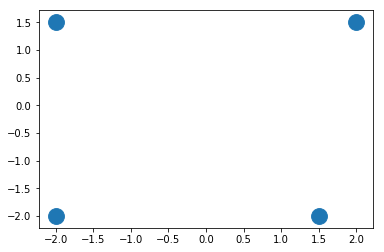

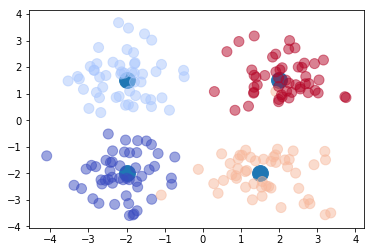

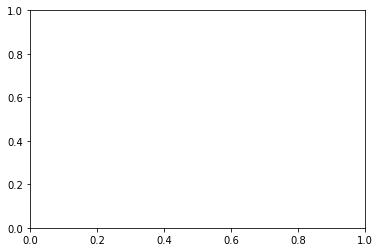

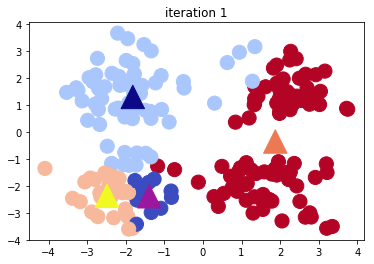

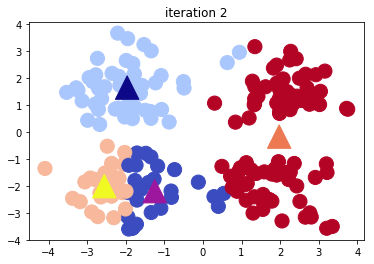

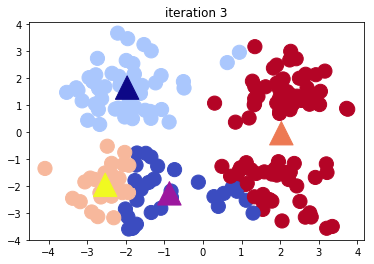

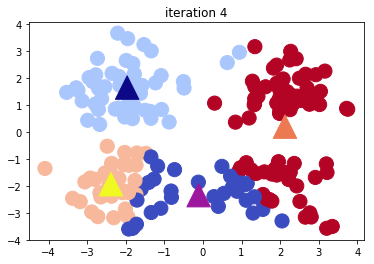

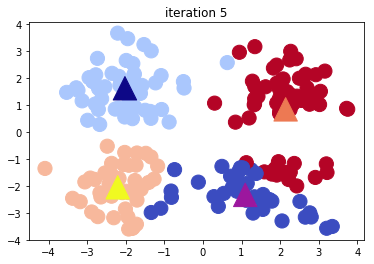

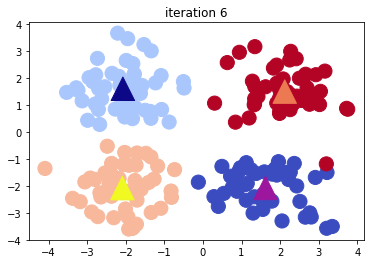

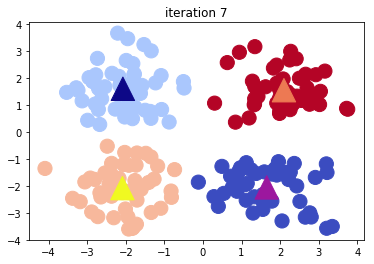

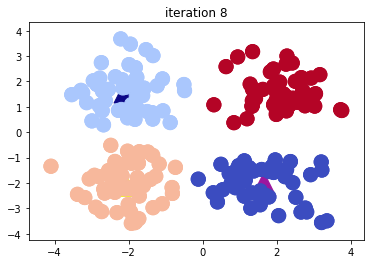

In [24]:
DATA_TYPE = 'blobs'
N = 200
if(DATA_TYPE == 'circle'):
    K = 2
else:
    K = 4

MAX_ITER = 1000

centers = np.array([[-2, -2], [-2, 1.5], [1.5, -2], [2, 1.5]])
print centers.shape

if(DATA_TYPE == 'circle'):
    data, features = make_circles(n_samples=N, shuffle=True, noise=0.01, factor=0.4)
else:
    data, features = make_blobs(n_samples=N, centers=centers, n_features=2, 
                                cluster_std=0.8, shuffle=False, random_state=42)

fig, ax = plt.subplots()
ax.scatter(centers[:, 0], centers[:, 1], marker='o', s=250)
plt.show()

fig, ax = plt.subplots()
if (DATA_TYPE == 'blobs'):
    ax.scatter(centers[:, 0], centers[:, 1], marker='o', s = 250)
    ax.scatter(data[:, 0], data[:, 1], marker='o', s=100, c=features, cmap=plt.cm.coolwarm, alpha=0.5)
    plt.plot()

points = tf.Variable(data)
cluster_assignments = tf.Variable(tf.zeros([N], dtype=tf.int64))
centroids = tf.Variable(tf.slice(points.initialized_value(), [0, 0], [K, 2]))

sess = tf.Session()
sess.run(tf.global_variables_initializer())

sess.run(centroids)

rep_centroids = tf.reshape(tf.tile(centroids, [N, 1]), [N, K, 2])
rep_points = tf.reshape(tf.tile(points, [1, K]), [N, K, 2])
sum_squares = tf.reduce_sum(tf.square(rep_points - rep_centroids), reduction_indices=2)
best_centroids = tf.argmin(sum_squares, 1)
did_assignment_change = tf.reduce_any(tf.not_equal(best_centroids, cluster_assignments))

def bucket_mean(data, bucket_ids, num_buckets):
    total = tf.unsorted_segment_sum(data, bucket_ids, num_buckets)
    count = tf.unsorted_segment_sum(tf.ones_like(data), bucket_ids, num_buckets)
    return total/count

means = bucket_mean(points, best_centroids, K)
with tf.control_dependencies([did_assignment_change]):
    do_updates = tf.group(centroids.assign(means), cluster_assignments.assign(best_centroids))
    
changed = True
iters = 0
fig, ax = plt.subplots()
if (DATA_TYPE == 'blobs'):
    colourindexes = [2,1,4,3]
else:
    colourindexes = [2,1]

while changed and iters < MAX_ITER:
    fig, ax = plt.subplots()
    iters += 1
    [changed, _] = sess.run([did_assignment_change, do_updates])
    [centers, assignments] = sess.run([centroids, cluster_assignments])
    ax.scatter(sess.run(points).transpose()[0], sess.run(points).transpose()[1], 
              marker='o', s = 200, c = assignments, cmap=plt.cm.coolwarm)
    ax.scatter(centers[:, 0], centers[:, 1], marker='^', s = 550, c = colourindexes, cmap=plt.cm.plasma)
    ax.set_title('iteration ' + str(iters))
ax.scatter(sess.run(points).transpose()[0], sess.run(points).transpose()[1], 
          marker='o', s = 200, c = assignments, cmap=plt.cm.coolwarm)
plt.show()
